# Reduce Test Data

This notebook will guide users through reducing the test data created by `create_test_data.py`. The simulated data contain 1000 images for each of OPTICam's three cameras. The observations have a 1 s cadence, and there is one variable source in the field.

The first step in reducing any OPTICam data is to initialise a `Reducer` object:

In [1]:
from opticam_new import Reducer

reducer = Reducer(
    data_directory='/path/to/test/data/',  # path to the simulated data
    out_directory='/path/to/output/directory/',  # path to where output will be saved
    show_plots=True,
    )

[OPTICAM] Scanning files ...


100%|██████████| 16/16 [00:00<00:00, 167.30it/s]

[OPTICAM] Done.
[OPTICAM] Binning: 8x8
[OPTICAM] Filters: g-band, i-band, r-band


We can see that the test data use an 8x8 binning, meaning the images are 256 pixels x 256 pixels. The observation times of the test data correspond to January 1st 2024, and the three filters used are "g", "i", and "r".

Let's initialise the source catalogs:

[OPTICAM] Initialising catalogs ...
[OPTICAM] Aligning and stacking g-band images in batches ...


100%|██████████| 16/16 [00:03<00:00,  4.19it/s]

[OPTICAM] Done. 0 image(s) could not be aligned.
[OPTICAM] Aligning and stacking i-band images in batches ...



100%|██████████| 16/16 [00:03<00:00,  4.13it/s]

[OPTICAM] Done. 0 image(s) could not be aligned.
[OPTICAM] Aligning and stacking r-band images in batches ...



100%|██████████| 16/16 [00:03<00:00,  4.08it/s]


[OPTICAM] Done. 0 image(s) could not be aligned.


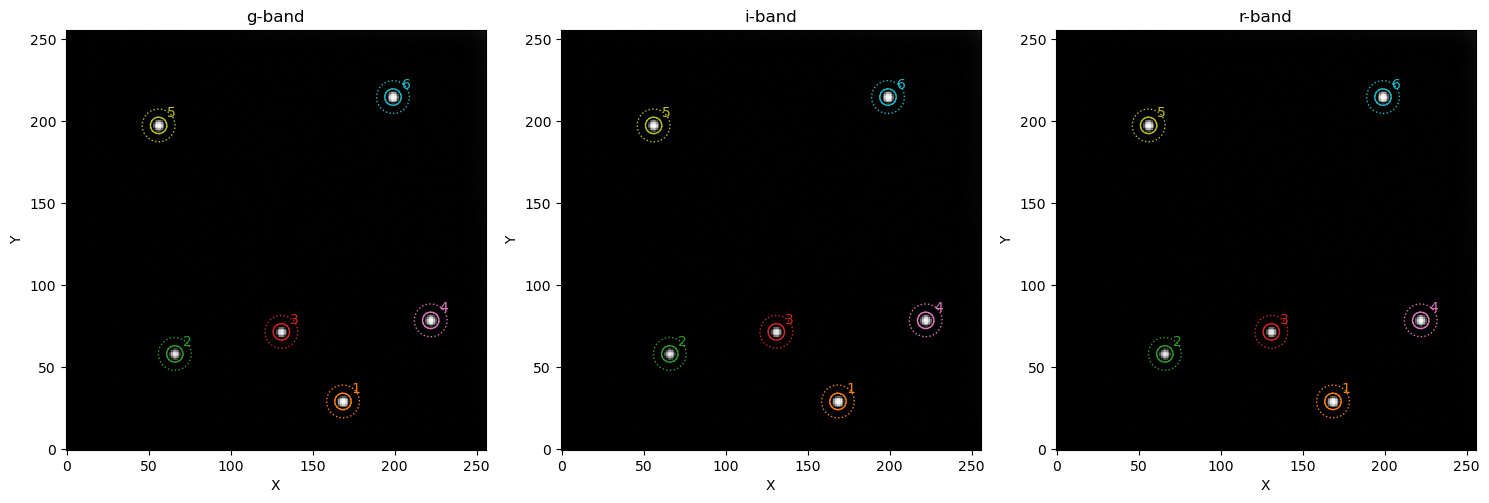

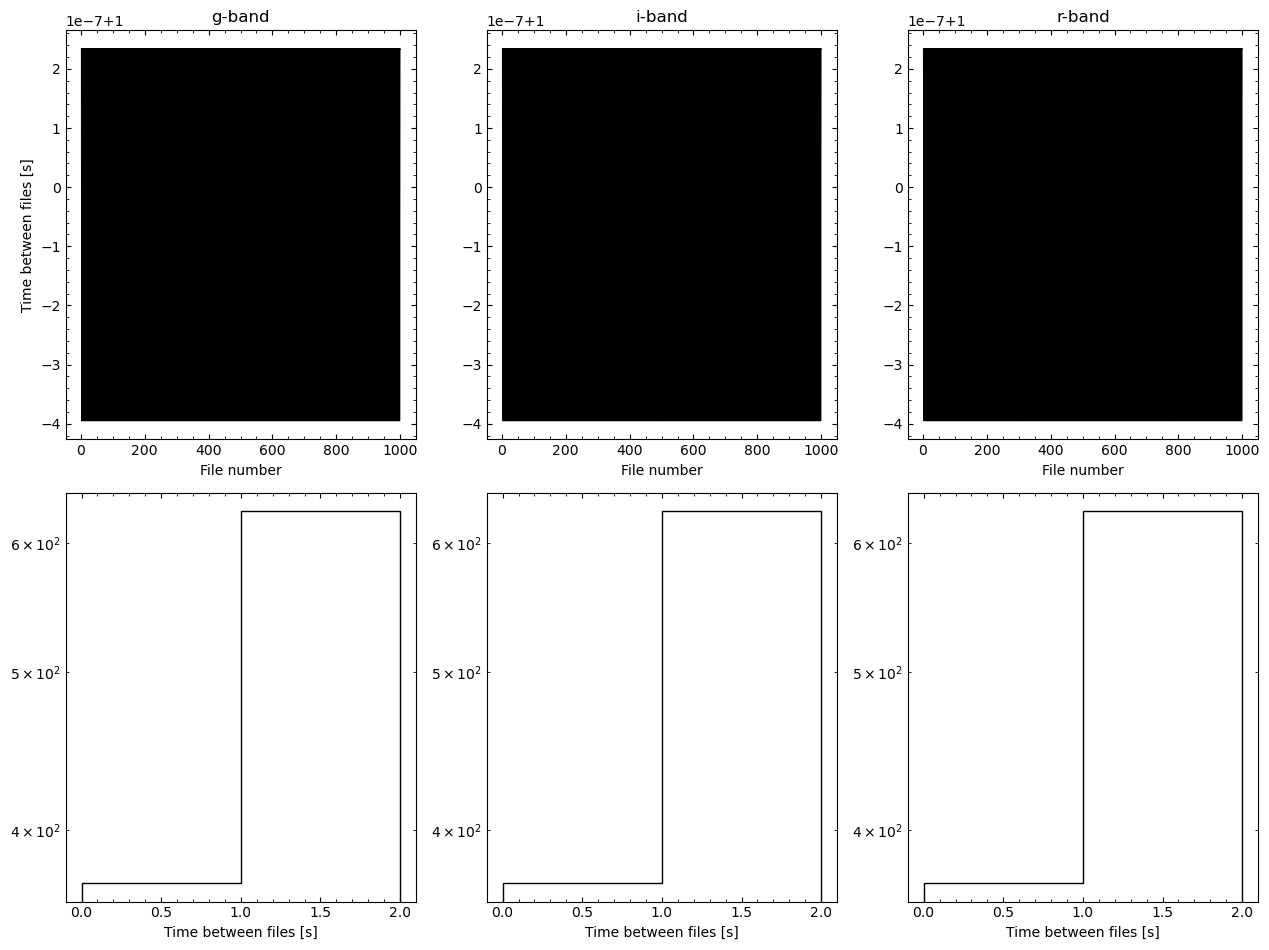

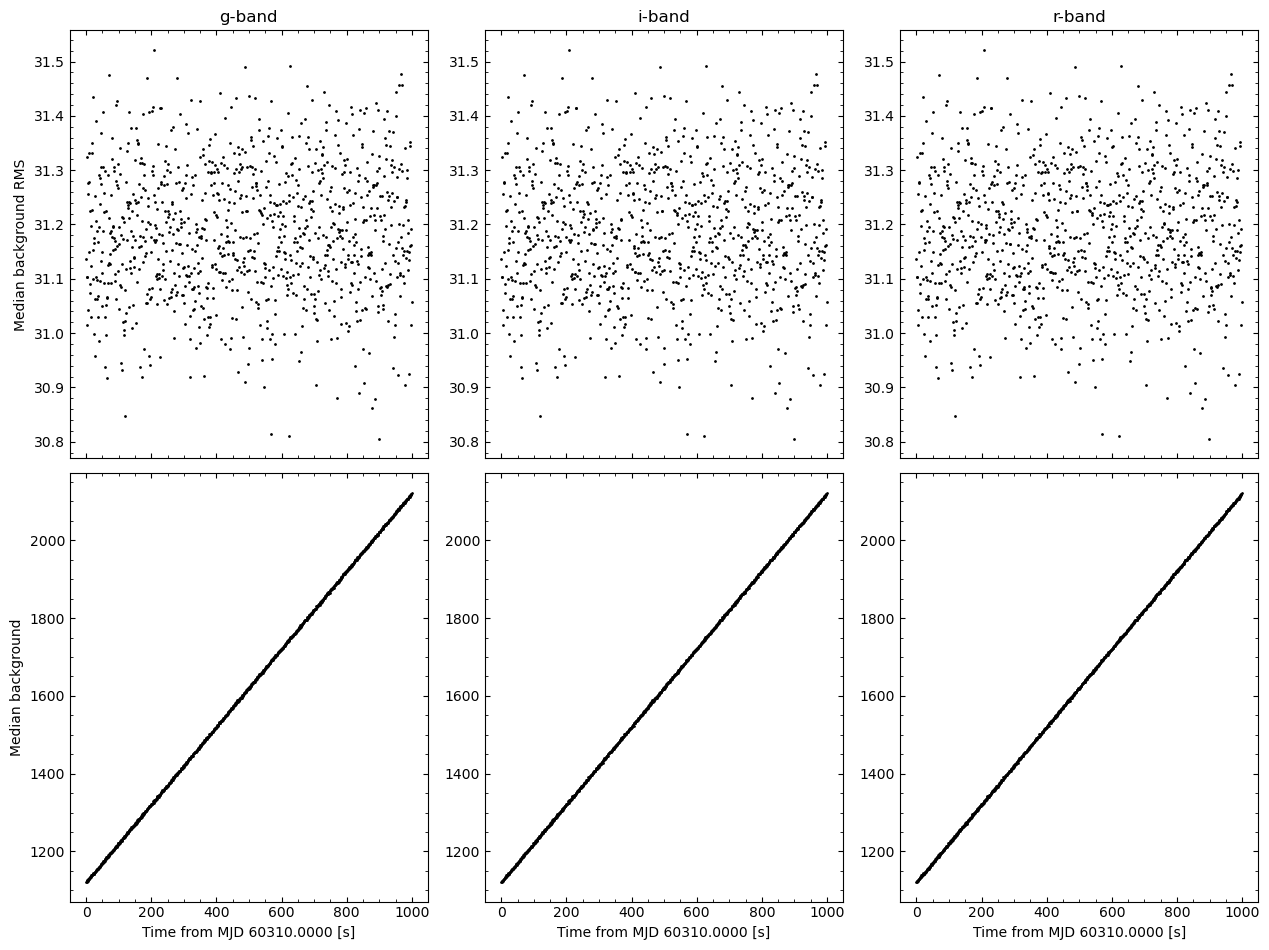

In [2]:
reducer.initialise_catalogs(overwrite=True)

We can see that all six sources have been identified in the catalog. In this example, the source labelling is consistent across the catalogs; this is because there are no field-of-view or pixel-scale differences between the simulated cameras. In practise, the source labelling will not usually be consistent across the catalogs, and so care must be taken when performing differential photometry that the same sources are being used for each filter. While initialising our catalogs, we also get diagnostic plots showing the time delta between images and a visualisation of the median background for each camera as a function of time. We can see that there are no time gaps in our observations, and our background is increasing over time for all three cameras.

With our catalogs defined, we can now perform aperture photometry. In this example, we will leverage all of the different photometry options currently available in `opticam_new`: 'aperture', 'annulus', 'normal', and 'optimal'. For more information about the different photometries, see the photometry tutorial. For 'aperture' and 'annulus' photometries, we need to call the `forced_photometry()` method using `phot_type='both'`:

In [3]:
reducer.forced_photometry(phot_type='both', overwrite=True)

[OPTICAM] Extracting aperture and annulus fluxes ...
[OPTICAM] Processing g-band files ...


100%|██████████| 16/16 [00:01<00:00,  8.20it/s]


[OPTICAM] Done.
[OPTICAM] Saving light curves ...


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

[OPTICAM] Done.
[OPTICAM] Processing i-band files ...



100%|██████████| 16/16 [00:01<00:00,  8.24it/s]


[OPTICAM] Done.
[OPTICAM] Saving light curves ...


100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

[OPTICAM] Done.
[OPTICAM] Processing r-band files ...



100%|██████████| 16/16 [00:02<00:00,  7.99it/s]


[OPTICAM] Done.
[OPTICAM] Saving light curves ...


 67%|██████▋   | 4/6 [00:01<00:00,  2.99it/s]

For 'normal' and 'optimal' photometries, we need to call the `photometry()` method (again using `phot_type='both'`):

In [ ]:
reducer.photometry(phot_type='both', overwrite=True)

Photometries available via the `photometry()` method require fitting for the source positions in each image; in some cases, this can mean that some sources do not have measureable fluxes in all images (depending on the value of 'threshold' specified when instancing a `Reducer()` object). As we can see above, all sources have 1000 detections, matching the number of observations. For performing differential photometry, the target source and all comparison sources must have partially matching detections.

In this example, we will assume that source 2 is our target of interest, and will use all other sources for comparisons. In practise, the choice of comparison star(s) is cruical for obtaining a quality final light curve. Even for stars that are known to be constant emitters, it is important to consider things like where the source is on the CCD (since the systematics can vary with posiiton). To choose suitable comparison sources, it is most instructive to inspect the raw light curves and choose those that look most similar and/or are close to the target source in the image (though this is beyond the scope of this tutorial). Let's now produce a relative light curve for source 2 using the 'annulus' fluxes. First, however, we need to initialise a `Photometer()` object:

In [ ]:
from opticam_new import Photometer

photometer = Photometer(reducer.out_directory)

When initialising a `Photometer()` object, the source catalogs are output for convenience. Let's now identify our target and comparison sources and create a relative light curve:

In [ ]:
target = 2
comparisons = [1, 3, 4, 5, 6]

analyser = photometer.get_relative_light_curve('g-band', target, comparisons, phot_type='annulus', prefix="test",
                                               match_other_cameras=True, show_diagnostics=False)

To help identify suitable comparison sources, residual plots are created between the target and each comparison source's normalized light curves. These plots are saved in `out_directory/relative_light_curves/diag`, and will be displayed unless `show_diagnostics` is set to `False`. Good comparison sources should have similar systematics to the target source, resulting in similarly shaped light curves (ignoring any intrinsic variability from the target).

When relative light curves are created, an `Analyser` object is returned. This analyser object can be used to perform a few basic analyses, such as computing power spectra and phase folding. In this case, we'll take a look at the power spectra for each camera and see if there's anything interesting there:

In [ ]:
frequencies, periodograms = analyser.lomb_scargle(scale='log')

As we can see, there is a strong signal at ~0.2 Hz (50 s period). However, since all the sources in each image have the nominal 1000 detections, we might see an improved signal-to-noise ratio if we instead use the 'optimal' fluxes:

In [ ]:
analyser = photometer.get_relative_light_curve('g-band', target, comparisons, phot_type='optimal', prefix="test",
                                               match_other_cameras=True, show_diagnostics=False)

Now the periodicity can be seen by eye. Let's check the new power spectrum:

In [ ]:
frequencies, powers = analyser.lomb_scargle(scale='log')

As we can see, the signal is much stronger. Let's also try phase folding to see the pulse shape:

In [ ]:
import numpy as np
import astropy.units as u

# NOTE: the period must be an astropy unit object (e.g. u.s, u.min, u.hour, u.day) to ensure the correct units are used
phases = analyser.phase_fold(period=50*u.s)

The large error bars can make the variations harder to see. In such cases, it may be preferable to phase bin the light curves instead:

In [ ]:
results = analyser.phase_bin(period=50*u.s)

The variations are much clearer now. We could use these plots to identify rotation/orbital periods, phase lags, etc., but this is beyond the scope of this tutorial.

That concludes this general introduction to `opticam_new`! For more specific documentation on each stage of the pipeline, see the dedicated tutorials.